In [1]:
pwd

'/workspace/hbp_cellpose/notebooks'

In [2]:
ls /data/special/h_e_tiles

B_118_FB10-SL_516-ST_HEOS-SE_1547_lossless.jpg*  url.txt*


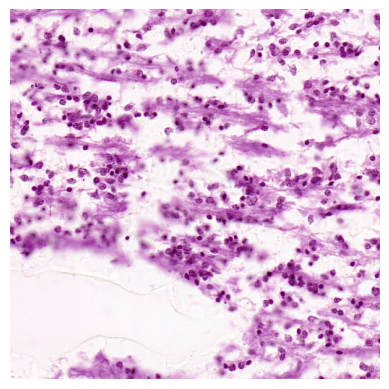

In [8]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import glob
# import matplotlib as mpl
# %matplotlib inline
# mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io

# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png']

urls = glob.glob('/data/special/h_e_tiles/*.jpg')

files = []
for url in urls:
    if url[0]=='h':
        parts = urlparse(url)
        filename = os.path.basename(parts.path)
    else:
        filename = url
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']

# view 1 image
img = io.imread(files[-1])
# plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='nuclei')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,0]] #, [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in for filename in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
for chan, filename in zip(channels, files):
    print(chan,filename)
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)

    # save results so you can load in gui
#     io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # save results as png
#     io.save_to_png(img, masks, flows, filename)

[0, 0] /data/special/h_e_tiles/B_118_FB10-SL_516-ST_HEOS-SE_1547_lossless.jpg


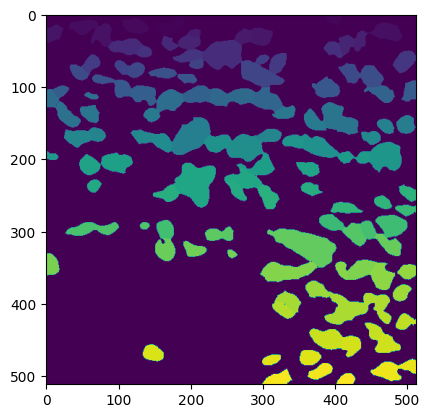

In [7]:
plt.imshow(masks)

In [ ]:
# # DISPLAY RESULTS
# from cellpose import plot

# fig = plt.figure(figsize=(12,5))
# plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
# plt.tight_layout()
# plt.show()

# with stain separation

In [122]:
from skimage.color import rgb2hed
from skimage.transform import resize
from skimage.filters import unsharp_mask as sharpen
from skimage.exposure import rescale_intensity, adjust_gamma

In [16]:
print(filename)

/data/special/h_e_tiles/B_118_FB10-SL_516-ST_HEOS-SE_1547_lossless.jpg


In [ ]:
img = io.imread(filename)

In [143]:
img2 = resize(img,[1024,1024],order=1)
img3 = sharpen(img2,channel_axis=2)
img4 = adjust_gamma(img3,1.8) 

In [188]:
hed = rgb2hed(img2)

In [189]:
slc = [slice(0,400),slice(0,400)]

/tmp/ipykernel_2697/1267358026.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.imshow(img2[slc])
/tmp/ipykernel_2697/1267358026.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.imshow(hed[slc+[0]],cmap='gray',vmax=0.1)
/tmp/ipykernel_2697/1267358026.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 

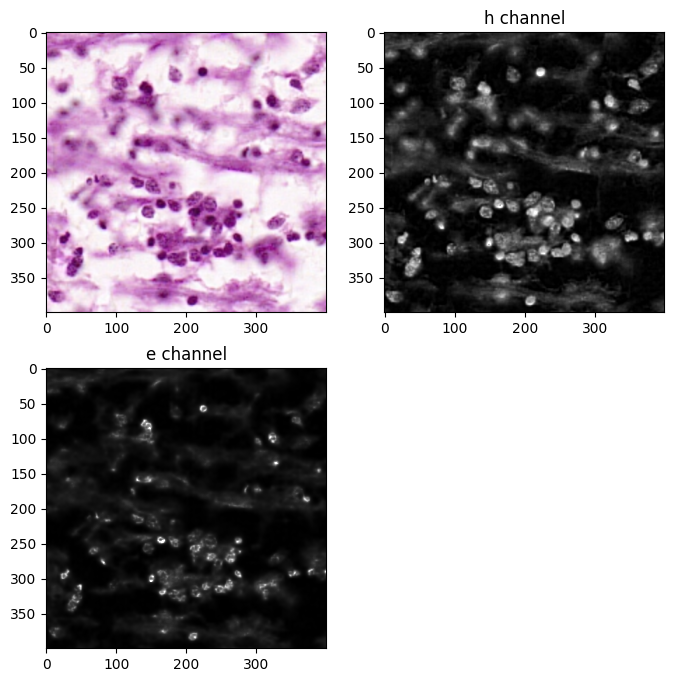

In [191]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(img2[slc])
plt.subplot(2,2,2)
plt.imshow(hed[slc+[0]],cmap='gray',vmax=0.1)
# plt.colorbar()
plt.title('h channel')
plt.subplot(2,2,3)
plt.imshow(hed[slc+[1]],cmap='gray',vmax=0.3)
# plt.colorbar()
_=plt.title('e channel')


In [197]:
h_channel = rescale_intensity(hed[...,0],in_range=(0,0.3))


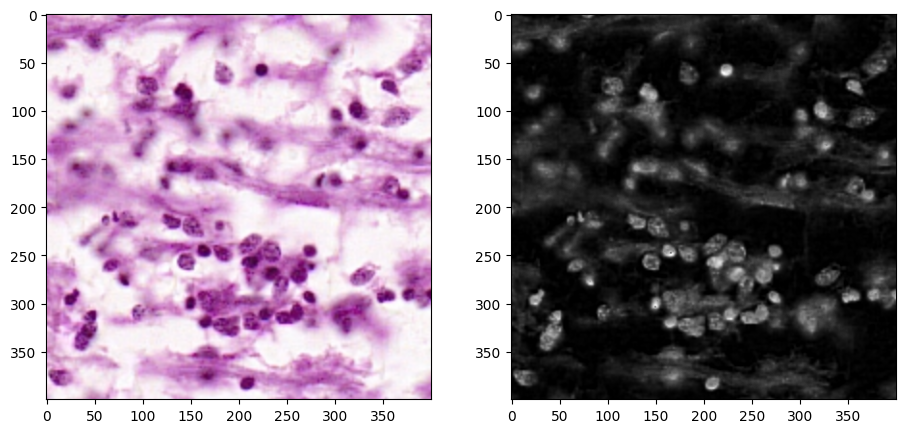

In [200]:
plt.figure(figsize=(2*400//72,400//72))
plt.subplot(1,2,1)
slc = slice(0,400),slice(0,400)
plt.imshow(img2[slc])
plt.subplot(1,2,2)
plt.imshow(h_channel[slc],cmap='gray') #,vmax=0.3)


# run inference

In [201]:
masks, flows, styles, diams = model.eval(h_channel, diameter=21, min_size=-1, flow_threshold=11, channels=[0,0])

In [202]:
masks.max()

394

# visualize

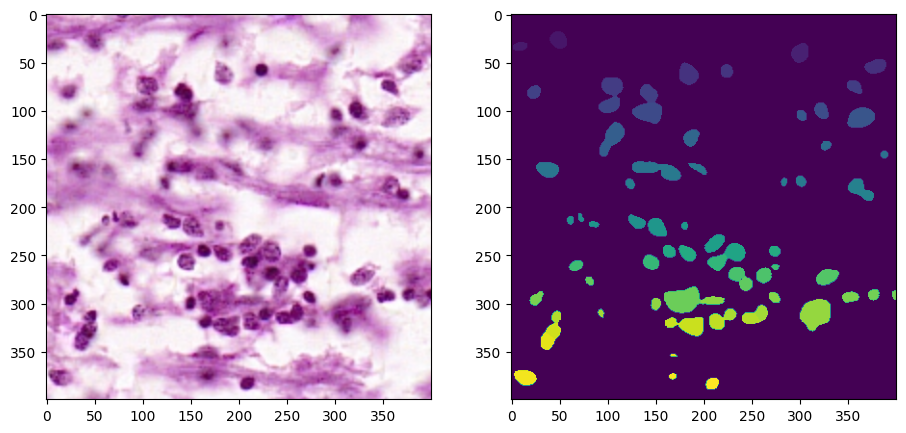

In [204]:
plt.figure(figsize=(2*400//72,400//72))
plt.subplot(1,2,1)

plt.imshow(img2[slc])
plt.subplot(1,2,2)
plt.imshow(masks[slc])
